In [1]:
!pip install kaggle

In [2]:
outfile = open("kaggle.json", "w")
outfile.write('{"username":"michaeldwa","key":"129431d10dfa26e93179400ec293cd4d"}')
outfile.close()

In [3]:
!ls

kaggle.json  sample_data


In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!ls /root/.kaggle/

kaggle.json


In [6]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [7]:
api.dataset_download_file("computingvictor/transactions-fraud-datasets", "transactions_data.csv")
api.dataset_download_file("computingvictor/transactions-fraud-datasets", "mcc_codes.json")
api.dataset_download_file("computingvictor/transactions-fraud-datasets", "train_fraud_labels.json")

Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets
Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets
Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets


True

In [8]:
transactions_file = "transactions_data.csv"
mcc_codes_file = "mcc_codes.json"
fraud_labels_file = "train_fraud_labels.json"
processed_output_file = "processed_transactions_2017_2019.csv"

In [9]:
!ls

mcc_codes.json	sample_data  train_fraud_labels.json  transactions_data.csv


In [10]:
import pandas as pd
import json

In [11]:
with open(mcc_codes_file, "r") as f:
    mcc_codes = json.load(f)

with open(fraud_labels_file, "r") as f:
    fraud_labels = json.load(f)['target']

In [12]:
# Define date range for filtering
start_date = '2017-11-01'
end_date = '2019-11-01'

In [13]:
# Read transactions incrementally
chunksize = 10**6  # Adjust based on system memory
processed_chunks = []

for chunk in pd.read_csv(transactions_file, parse_dates=['date'], chunksize=chunksize):
    # Filter rows based on the date range
    filtered_chunk = chunk.loc[(chunk['date'] >= start_date) & (chunk['date'] <= end_date)].copy()

    # Add MCC descriptions
    filtered_chunk.loc[:, 'mcc_description'] = filtered_chunk['mcc'].astype(str).map(mcc_codes)

    # Add fraud labels
    filtered_chunk.loc[:, 'fraud_label'] = filtered_chunk['id'].astype(str).map(fraud_labels)

    # Append processed chunk
    processed_chunks.append(filtered_chunk)

In [14]:
# Combine all processed chunks into a single DataFrame
final_data = pd.concat(processed_chunks, ignore_index=True)
final_data.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_description,fraud_label
0,20316458,2017-11-01 00:00:00,641,2774,$58.75,Chip Transaction,20561,Columbus,OH,43228.0,5912,NaN,Drug Stores and Pharmacies,No
1,20316459,2017-11-01 00:01:00,1697,3295,$0.30,Chip Transaction,61968,Clinton,MI,49236.0,5912,NaN,Drug Stores and Pharmacies,No
2,20316460,2017-11-01 00:03:00,316,5857,$96.03,Chip Transaction,20561,Houston,TX,77048.0,5912,NaN,Drug Stores and Pharmacies,No
3,20316461,2017-11-01 00:04:00,1797,5660,$58.75,Chip Transaction,54343,San Leandro,CA,94577.0,4121,NaN,Taxicabs and Limousines,No
4,20316462,2017-11-01 00:05:00,1682,2517,$21.18,Swipe Transaction,77736,Grand Forks,ND,58201.0,5921,NaN,"Package Stores, Beer, Wine, Liquor",No


In [15]:
# Save the processed data
final_data.to_csv(processed_output_file, index=False)
print(f"Processed data saved to '{processed_output_file}'")

Processed data saved to 'processed_transactions_2017_2019.csv'


In [16]:
# Cleaning data
cleaned_output_path = "cleaned_transactions_2017_2019.csv"
processed_data = pd.read_csv(processed_output_file, parse_dates=['date'])
processed_data.head(3)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_description,fraud_label
0,20316458,2017-11-01 00:00:00,641,2774,$58.75,Chip Transaction,20561,Columbus,OH,43228.0,5912,NaN,Drug Stores and Pharmacies,No
1,20316459,2017-11-01 00:01:00,1697,3295,$0.30,Chip Transaction,61968,Clinton,MI,49236.0,5912,NaN,Drug Stores and Pharmacies,No
2,20316460,2017-11-01 00:03:00,316,5857,$96.03,Chip Transaction,20561,Houston,TX,77048.0,5912,NaN,Drug Stores and Pharmacies,No


In [17]:
# 1. Drop unnecessary columns
columns_to_drop = ['errors']  # Add other unused columns here
processed_data = processed_data.drop(columns=columns_to_drop)
processed_data.head(3)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,mcc_description,fraud_label
0,20316458,2017-11-01 00:00:00,641,2774,$58.75,Chip Transaction,20561,Columbus,OH,43228.0,5912,Drug Stores and Pharmacies,No
1,20316459,2017-11-01 00:01:00,1697,3295,$0.30,Chip Transaction,61968,Clinton,MI,49236.0,5912,Drug Stores and Pharmacies,No
2,20316460,2017-11-01 00:03:00,316,5857,$96.03,Chip Transaction,20561,Houston,TX,77048.0,5912,Drug Stores and Pharmacies,No


In [18]:
# 2. Handle missing values
processed_data['merchant_state'] = processed_data['merchant_state'].fillna('Unknown')
processed_data['mcc_description'] = processed_data['mcc_description'].fillna('Unknown MCC')

In [19]:
# 3. Normalize the `amount` column
processed_data['amount'] = processed_data['amount'].str.replace(r'[\$,]', '', regex=True).astype(float)
processed_data['amount'].head(3)

,amount
0,58.75
1,0.30
2,96.03


In [20]:
# 4. Convert fraud labels to binary (handle missing or invalid values)
processed_data['fraud_label'] = processed_data['fraud_label'].fillna('no')  # Default to 'no' for NaN
processed_data['fraud_label'] = processed_data['fraud_label'].str.strip().str.lower().map({'yes': 1, 'no': 0})
processed_data['fraud_label'].head(3)

,fraud_label
0,0
1,0
2,0


In [21]:
# 6. Remove duplicates
processed_data = processed_data.drop_duplicates()
processed_data.head(3)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,mcc_description,fraud_label
0,20316458,2017-11-01 00:00:00,641,2774,58.75,Chip Transaction,20561,Columbus,OH,43228.0,5912,Drug Stores and Pharmacies,0
1,20316459,2017-11-01 00:01:00,1697,3295,0.30,Chip Transaction,61968,Clinton,MI,49236.0,5912,Drug Stores and Pharmacies,0
2,20316460,2017-11-01 00:03:00,316,5857,96.03,Chip Transaction,20561,Houston,TX,77048.0,5912,Drug Stores and Pharmacies,0


In [22]:
# 7. Clean and validate zip codes
processed_data['zip'] = processed_data['zip'].fillna(0).astype(int)  # Replace NaN with 0 and convert to int
processed_data['zip'].head(3)

,zip
0,43228
1,49236
2,77048


In [23]:
# 8. Ensure consistent MCC descriptions
processed_data['mcc_description'] = processed_data['mcc_description'].str.strip()
processed_data['mcc_description'].head(3)

,mcc_description
0,Drug Stores and Pharmacies
1,Drug Stores and Pharmacies
2,Drug Stores and Pharmacies


In [24]:
# Save the cleaned dataset
processed_data.to_csv(cleaned_output_path, index=False)
print(f"Cleaned data saved to {cleaned_output_path}")
processed_data.head(3)

Cleaned data saved to cleaned_transactions_2017_2019.csv


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,mcc_description,fraud_label
0,20316458,2017-11-01 00:00:00,641,2774,58.75,Chip Transaction,20561,Columbus,OH,43228,5912,Drug Stores and Pharmacies,0
1,20316459,2017-11-01 00:01:00,1697,3295,0.30,Chip Transaction,61968,Clinton,MI,49236,5912,Drug Stores and Pharmacies,0
2,20316460,2017-11-01 00:03:00,316,5857,96.03,Chip Transaction,20561,Houston,TX,77048,5912,Drug Stores and Pharmacies,0


In [25]:
#Data Analysis
df = processed_data
df.head(3)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,mcc_description,fraud_label
0,20316458,2017-11-01 00:00:00,641,2774,58.75,Chip Transaction,20561,Columbus,OH,43228,5912,Drug Stores and Pharmacies,0
1,20316459,2017-11-01 00:01:00,1697,3295,0.30,Chip Transaction,61968,Clinton,MI,49236,5912,Drug Stores and Pharmacies,0
2,20316460,2017-11-01 00:03:00,316,5857,96.03,Chip Transaction,20561,Houston,TX,77048,5912,Drug Stores and Pharmacies,0


In [26]:
#Personal Spending calculations based on client id

psc = df[["client_id", "amount", "mcc_description"]]
psc.head(3)

,client_id,amount,mcc_description
0,641,58.75,Drug Stores and Pharmacies
1,1697,0.30,Drug Stores and Pharmacies
2,316,96.03,Drug Stores and Pharmacies


In [27]:
#Grouping all transactions by client id

client_amount = psc.groupby("client_id")
client_amount.get_group(0)

,client_id,amount,mcc_description
2171,0,44.83,Drug Stores and Pharmacies
5777,0,-96.00,Miscellaneous Food Stores
5804,0,96.00,Miscellaneous Food Stores
5909,0,85.30,Miscellaneous Food Stores
6277,0,13.28,Discount Stores
...,...,...,...
2781426,0,60.97,Drinking Places (Alcoholic Beverages)
2783388,0,59.71,Lumber and Building Materials
2785754,0,86.65,Wholesale Clubs
2786706,0,21.89,Postal Services - Government Only


In [28]:
#Computing highest spending category for each client

client_max_spending = client_amount.max()
client_max_spending

,amount,mcc_description
client_id,,
0,889.30,Women's Ready-To-Wear Stores
1,937.15,Wholesale Clubs
2,333.00,Women's Ready-To-Wear Stores
3,778.75,Women's Ready-To-Wear Stores
4,1579.57,Women's Ready-To-Wear Stores
...,...,...
1994,1614.02,Wholesale Clubs
1995,950.88,Women's Ready-To-Wear Stores
1996,597.06,Wholesale Clubs


In [29]:
#categorizing highest spending by mcc codes
client_max_plot = client_max_spending.groupby("mcc_description").count()
client_max_plot

,amount
mcc_description,
Wholesale Clubs,580
Women's Ready-To-Wear Stores,630


<Axes: title={'center': 'Highest spending categories for all clients'}, xlabel='mcc_description', ylabel='Count'>

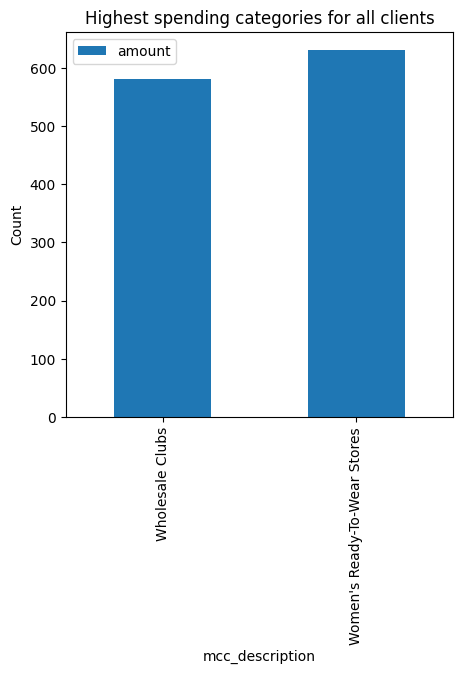

In [30]:
#Plot to visualize the count of client spending max amount on a mcc
client_max_plot.plot(kind="bar", figsize=(5,5), title='Highest spending categories for all clients', ylabel='Count')

In [31]:
#Total amount spent by all client in 2 years on each mcc category

top_mcc = df[["mcc_description", "amount"]]
top_mcc.head(3)

,mcc_description,amount
0,Drug Stores and Pharmacies,58.75
1,Drug Stores and Pharmacies,0.30
2,Drug Stores and Pharmacies,96.03


In [32]:
#Calculating top 10 mcc categories with most money spent

top_mcc_amt = top_mcc.groupby("mcc_description").sum()
top_mcc_plot = top_mcc_amt.sort_values("amount", ascending=False)
top_mcc_plot.head(10)

,amount
mcc_description,
Money Transfer,10981963.56
"Grocery Stores, Supermarkets",8550165.47
Wholesale Clubs,7783664.91
Drug Stores and Pharmacies,7274150.29
Service Stations,6090272.63
"Utilities - Electric, Gas, Water, Sanitary",5779859.13
Department Stores,5609618.44
Eating Places and Restaurants,5494122.32
Tolls and Bridge Fees,5343365.94


<Axes: title={'center': 'Top 10 MCC vs Total amount spent'}, xlabel='Total amount spent', ylabel='mcc_description'>

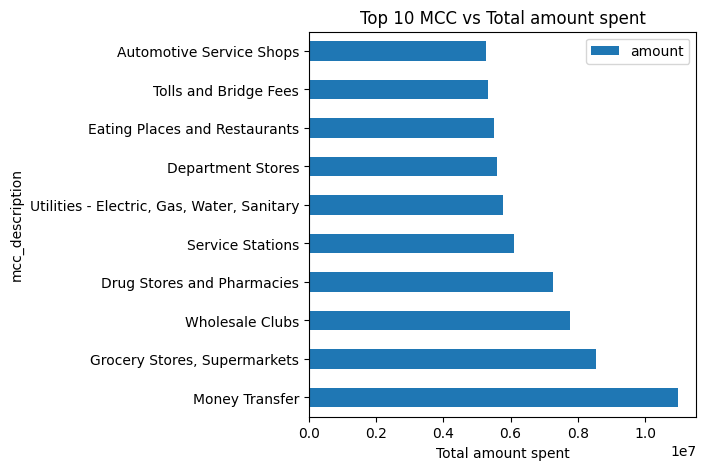

In [33]:
#Plot for top 10 mcc codes for 2 years of transactions

top_mcc_plot.head(10).plot(kind="barh", figsize=(5,5), title="Top 10 MCC vs Total amount spent", xlabel="Total amount spent")

In [34]:
#Fraud analysis for each transaction

fraud_ck = df[["use_chip","fraud_label"]]
fraud_ck.head(3)

,use_chip,fraud_label
0,Chip Transaction,0
1,Chip Transaction,0
2,Chip Transaction,0


In [35]:
#Counting total number of transactions for each type

transaction_type = fraud_ck.groupby("use_chip").count()
transaction_type

,fraud_label
use_chip,
Chip Transaction,1980743
Online Transaction,336982
Swipe Transaction,471370


In [36]:
#Categorizing the fraud alerts based on the type of transaction (chip, online, swipe)

fr_aler = fraud_ck[fraud_ck.fraud_label ==1]
fr_count = fr_aler.groupby("use_chip").count()
fr_count

,fraud_label
use_chip,
Chip Transaction,2795
Online Transaction,85
Swipe Transaction,281


In [37]:
#Calculating percentage fraud in each category
perc_fr = (fr_count.fraud_label/transaction_type.fraud_label)*100
perc_fr

,fraud_label
use_chip,
Chip Transaction,0.141109
Online Transaction,0.025224
Swipe Transaction,0.059613


<Axes: title={'center': 'Fraud occurance by categories'}, ylabel='fraud_label'>

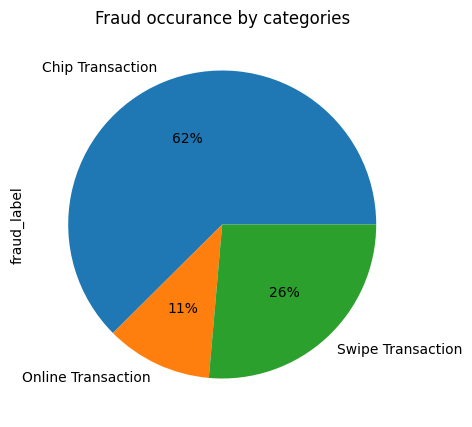

In [ ]:
#Plot to identify the percentage of fraud
perc_fr.plot(kind='pie', autopct='%1.0f%%', figsize=(5,5), title='Fraud occurance by categories')

In [ ]:
#Data Export